# Word level language modeling

# After preprocessing and converting the document into tokens ,the tokens are organized in a sequence and stored into a text file.

In [1]:
import string
%matplotlib inline
import matplotlib.pyplot as plt

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# turn a doc into clean tokens
def clean_doc(doc):
	# replace '--' with a space ' '
	doc = doc.replace('--', ' ')
	# split into tokens by white space
	tokens = doc.split()
	# remove punctuation from each token
	table = str.maketrans('', '', string.punctuation)
	tokens = [w.translate(table) for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# make lower case
	tokens = [word.lower() for word in tokens]
	return tokens

# save tokens to file, one dialog per line
def save_doc(lines, filename):
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

# load document
in_filename = 'speech.txt'
doc = load_doc(in_filename)
print(doc[:200])

# clean document
tokens = clean_doc(doc)
print(tokens[:200])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

# organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
	# select sequence of tokens
	seq = tokens[i-length:i]
	# convert into a line
	line = ' '.join(seq)
	# store
	sequences.append(line)
print('Total Sequences: %d' % len(sequences))

# save sequences to file
out_filename = 'speech1.txt'
save_doc(sequences, out_filename)


I want to start by appreciating my sisters and brothers here with today; H.E. Ms. Otiko Afisa Djaba, Minister for Gender, Children and Social Protection, Ghana is here, because Ghana in the African Un
['i', 'want', 'to', 'start', 'by', 'appreciating', 'my', 'sisters', 'and', 'brothers', 'here', 'with', 'today', 'he', 'ms', 'otiko', 'afisa', 'djaba', 'minister', 'for', 'gender', 'children', 'and', 'social', 'protection', 'ghana', 'is', 'here', 'because', 'ghana', 'in', 'the', 'african', 'union', 'is', 'the', 'champion', 'for', 'gender', 'and', 'development', 'so', 'we', 'are', 'in', 'a', 'good', 'place', 'we', 'have', 'our', 'sister', 'and', 'advocate', 'on', 'women', 'peace', 'and', 'security', 'ms', 'bineta', 'diop', 'special', 'envoy', 'on', 'women', 'peace', 'and', 'security', 'african', 'union', 'commission', 'we', 'have', 'ambassador', 'patricia', 'flor', 'directorgeneral', 'for', 'international', 'order', 'united', 'nations', 'and', 'arms', 'control', 'at', 'the', 'german', 'fede

# The tokens saved in the text file are encoded to integers and then fed to the model which gives the train and test accuracy.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 50)            138150    
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 700)           2102800   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 700)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 700)               3922800   
_________________________________________________________________
dropout_4 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 700)               490700    
_________________________________________________________________
dense_4 (Dense)              (None, 2763)              1936863   
Total para

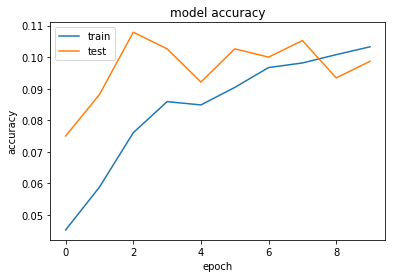

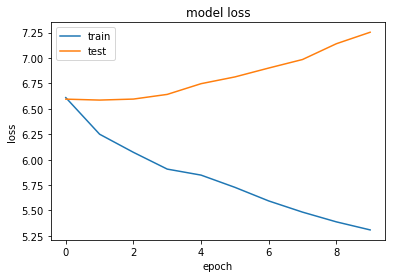

In [4]:
from numpy import array
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Embedding

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load
in_filename = 'speech1.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# separate into input and output
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

# define model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(700, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(700))
model.add(Dropout(0.2))
model.add(Dense(700, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history=model.fit(X, y,validation_split=0.05, batch_size=128, epochs=10)
#model.fit(X, y, validation_split=0.33, epochs=50, batch_size=10, verbose=0)
#model.save('model.h5')
#dump(tokenizer, open('tokenizer.pkl', 'wb'))
# list all data in history
print(history.history.keys())
# summarize history for accuracy

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# save the model to file
model.save('model.h5')
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

# The language model now generates text on the basis of the trained data.

In [2]:
from random import randint
from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
	result = list()
	in_text = seed_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		# truncate sequences to a fixed length
		encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
		# predict probabilities for each word
		yhat = model.predict_classes(encoded, verbose=0)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text += ' ' + out_word
		result.append(out_word)
	return ' '.join(result)

# load cleaned text sequences
in_filename = 'speech1.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
seq_length = len(lines[0].split()) - 1

# load the model
model = load_model('model.h5')

# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))

# select a seed text
seed_text = lines[randint(0,len(lines))]
print(seed_text + '\n')
print("End OF SEED \n")

# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 100)
print(generated)

 
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
 
# select a seed text
seed_text = lines[randint(0,len(lines))]
print(seed_text + '\n')
 
# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text,100)
print(generated)


C:\Users\Tulika\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


lifesaving work that is done by unfpa and through that partnership we are able to bring together our collective strengths to serve the women next year the commission on the status of women will be focusing on rural women i hope that we can start now working together on how we

End OF SEED 

will position these rural women bringing together all our citizens around their needs sure i do not have to tell this audience how challenged rural women are it is going to be our coordination that will ensure we are able to address rural women as effectively as we can as we address rural women we also bring attention to women with disabilities to indigenous women and many other women who are challenged by intersectionalities that make their case even worse so thank you so much to all the conveners of this meeting for bringing us together in this session thank
changing the economic value of women for instance ensuring that as many countries as possible take concrete actions to address the ending of 